# Triton Puzzle 1: Vector Addition

Welcome to the first Triton puzzle! In this tutorial, we'll implement the simplest possible GPU kernel: element-wise vector addition.

### What you'll learn:
- How to write a basic Triton kernel
- The difference between HBM and SRAM in GPU programming
- How to use Triton's pointer arithmetic and masking
- How to benchmark GPU kernels against PyTorch

## Mathematical Background

Vector addition is one of the simplest operations in linear algebra. Given two vectors $\mathbf{x}$ and $\mathbf{y}$ of length $n$:

$$\mathbf{x} = [x_1, x_2, ..., x_n]$$
$$\mathbf{y} = [y_1, y_2, ..., y_n]$$

The element-wise addition is:

$$\mathbf{z} = \mathbf{x} + \mathbf{y} = [x_1 + y_1, x_2 + y_2, ..., x_n + y_n]$$

### Memory Operations Analysis

For vector addition, we need to:
- **Read** $n$ elements from vector $\mathbf{x}$ (from HBM to SRAM)
- **Read** $n$ elements from vector $\mathbf{y}$ (from HBM to SRAM)
- **Compute** $n$ additions (on SRAM)
- **Write** $n$ elements to vector $\mathbf{z}$ (from SRAM to HBM)

Cost:
- Total memory operations: $3n$ (2 reads + 1 write)
- Total FLOPs: $n$ (additions)

In [ ]:
import torch
import triton
import triton.language as tl
import time
import numpy as np
from IPython.display import Image, display

# Set up device
DEVICE = torch.device(f'cuda:{torch.cuda.current_device()}')
print(f"Using device: {DEVICE}")

## Implementation 1: Raw PyTorch

Let's start with the simplest implementation using PyTorch's built-in operations.


In [ ]:
def add_pytorch(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """Element-wise vector addition using PyTorch."""
    return x + y

## Implementation 2: PyTorch with torch.compile

PyTorch 2.0 introduced `torch.compile` which can optimize operations by fusing kernels and reducing memory traffic.

In [ ]:
@torch.compile
def add_pytorch_compiled(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """Element-wise vector addition using torch.compile."""
    return x + y

## Implementation 3: Triton Kernel (Puzzle)

Now for the main challenge! Implement vector addition using Triton.

### Key Triton Concepts:

1. **Programs and Blocks**: Triton launches multiple "programs" in parallel. Each program processes a block of data.
2. **Pointers**: Triton uses pointer arithmetic similar to C/C++.
3. **Masking**: To handle edge cases where data size isn't perfectly divisible by block size.
4. **SRAM vs HBM**: Load data from slow HBM to fast SRAM, compute, then store back.

### Your Task:
Complete the Triton kernel below. You need to:
1. Calculate which block this program should process
2. Create offsets for memory access
3. Load data from x and y
4. Perform the addition
5. Store the result

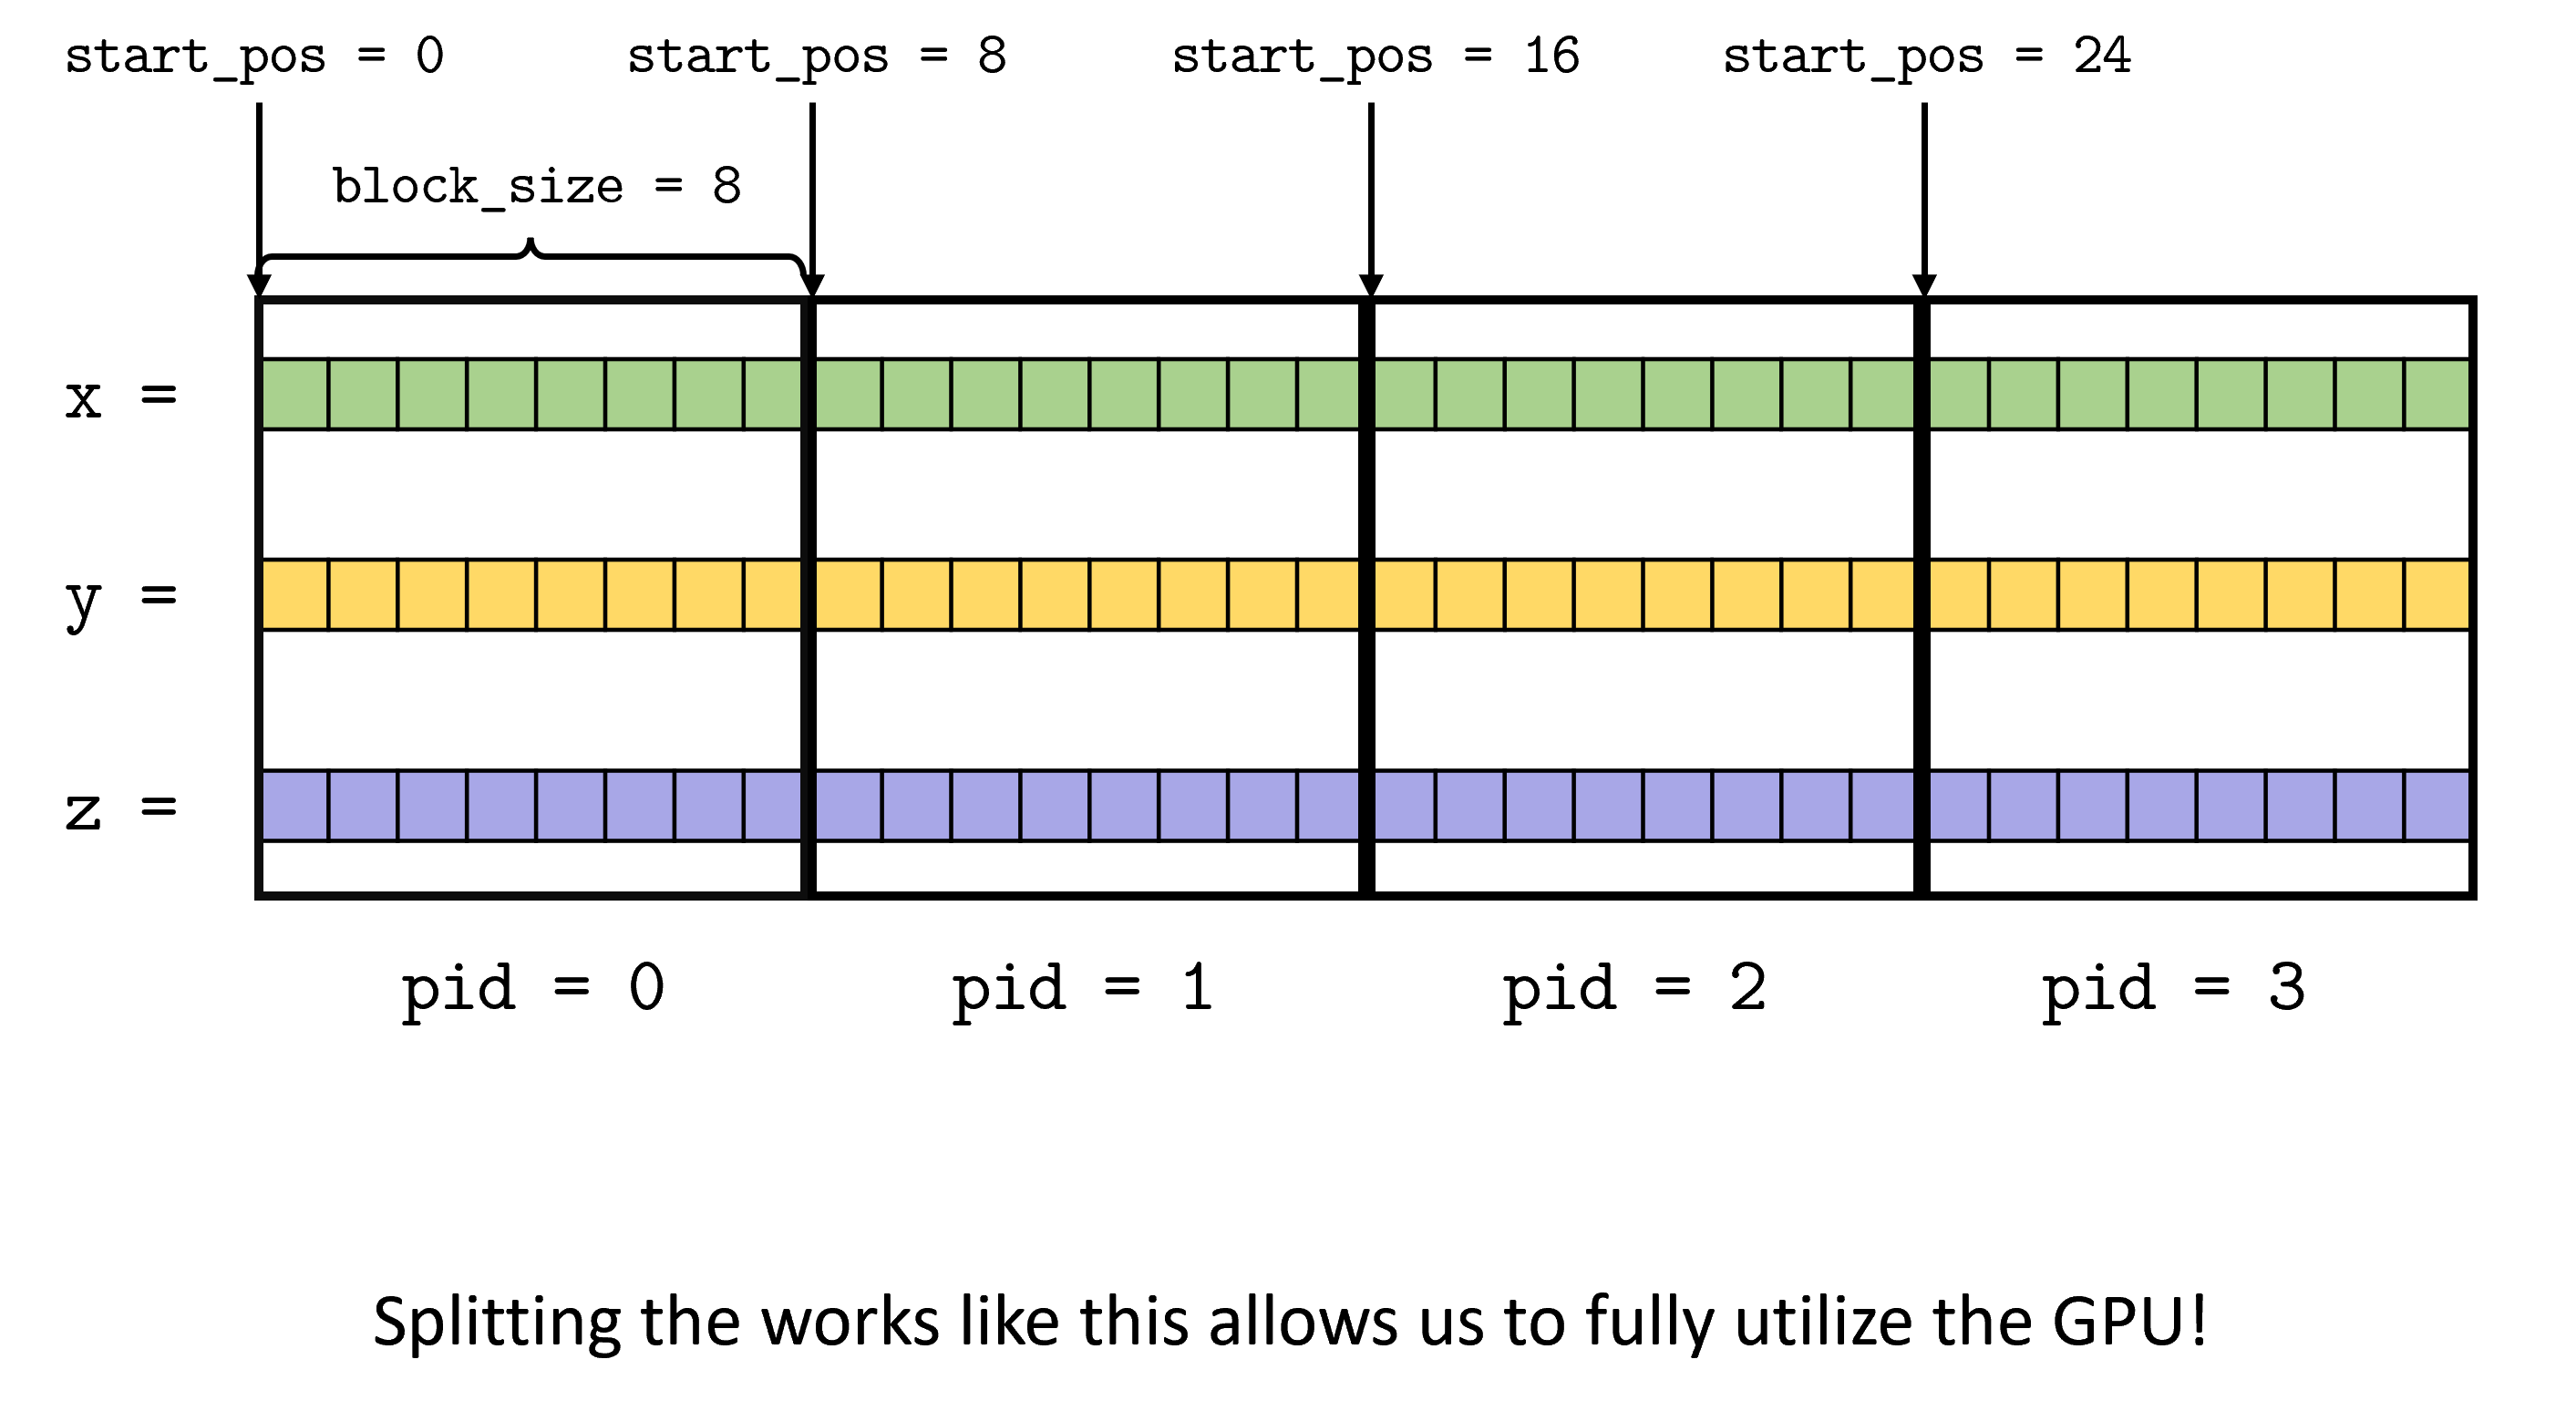

In [ ]:
Image("vector_add.png")

In [ ]:
@triton.jit
def add_kernel(
    x_ptr,  # Pointer to first input vector
    y_ptr,  # Pointer to second input vector
    output_ptr,  # Pointer to output vector
    n_elements,  # Size of the vectors
    BLOCK_SIZE: tl.constexpr,  # Number of elements each program processes
):
    """
    Triton kernel for element-wise vector addition.
    Each program instance processes BLOCK_SIZE elements.
    """
    # YOUR IMPLEMENTATION GOES HERE
    pass

In [ ]:
# Wrapper function for the Triton kernel
def add_triton(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Wrapper function for the Triton vector addition kernel.
    Handles output allocation and kernel launching.
    """
    # Ensure inputs are contiguous and on the correct device
    x = x.contiguous()
    y = y.contiguous()
    
    # Allocate output tensor
    output = torch.empty_like(x)
    
    # Get the number of elements
    n_elements = output.numel()
    
    # Define block size (must be power of 2)
    BLOCK_SIZE = 1024  # we will see later how we can optimize this!
    
    # Calculate grid size (number of programs to launch)
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']),)
    
    # Launch kernel
    add_kernel[grid](
        x, y, output, n_elements,
        BLOCK_SIZE=BLOCK_SIZE,
    )
    
    return output

## Solution (Hidden)
<font size="6">🧙</font> You shall not pass!

In [ ]:
@triton.jit
def add_kernel(
    x_ptr,
    y_ptr,
    output_ptr,
    n_elements,
    BLOCK_SIZE: tl.constexpr,
):
    """
    Triton kernel for element-wise vector addition.
    Each program instance processes BLOCK_SIZE elements.
    """
    # Identify which program we are
    pid = tl.program_id(axis=0)
    
    # Calculate the starting index for this program
    block_start = pid * BLOCK_SIZE
    
    # Create a range of offsets for this block
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    
    # Create a mask to guard against out-of-bounds accesses
    mask = offsets < n_elements
    
    # Load x and y from DRAM to SRAM
    x = tl.load(x_ptr + offsets, mask=mask, other=0.0)
    y = tl.load(y_ptr + offsets, mask=mask, other=0.0)
    
    # Perform the addition on SRAM
    output = x + y
    
    # Write the result back to DRAM
    tl.store(output_ptr + offsets, output, mask=mask)


## FLOP Analysis

Let's count the floating-point operations for each implementation.

In [ ]:
def count_flops(n_elements):
    """
    Count FLOPs for vector addition.
    
    Vector addition performs 1 addition per element.
    """
    return n_elements

def analyze_memory_ops(n_elements):
    """
    Analyze memory operations for vector addition.
    
    Returns:
        dict: Memory operations breakdown
    """
    return {
        'reads': 2 * n_elements,  # Read x and y
        'writes': n_elements,     # Write output
        'total': 3 * n_elements,  # Total memory ops
        'arithmetic_intensity': 1/3  # FLOPs per memory op
    }

# Test FLOP counting
n = 1_000_000
flops = count_flops(n)
mem_ops = analyze_memory_ops(n)

print(f"Vector addition for {n:,} elements:")
print(f"  FLOPs: {flops:,}")
print(f"  Memory reads: {mem_ops['reads']:,}")
print(f"  Memory writes: {mem_ops['writes']:,}")
print(f"  Total memory ops: {mem_ops['total']:,}")
print(f"  Arithmetic intensity: {mem_ops['arithmetic_intensity']:.3f} FLOPs/byte")

## Testing Correctness

Let's verify that our Triton implementation produces the same results as PyTorch.

In [ ]:
def test_correctness(size=1000000, atol=1e-5, rtol=1e-5):
    """Test if Triton implementation matches PyTorch."""
    # Create random input tensors
    torch.manual_seed(42)
    x = torch.randn(size, device=DEVICE, dtype=torch.float32)
    y = torch.randn(size, device=DEVICE, dtype=torch.float32)
    
    # Compute with PyTorch
    expected = add_pytorch(x, y)
    
    # Compute with Triton
    actual = add_triton(x, y)
    
    # Check if results match
    try:
        torch.testing.assert_close(actual, expected, atol=atol, rtol=rtol)
        print(f"✅ Test PASSED!")
        print(f"   Max absolute difference: {(actual - expected).abs().max().item():.2e}")
        return True
    except AssertionError as e:
        print(f"❌ Test FAILED!")
        print(f"   Error: {e}")
        return False

# Run the test
test_passed = test_correctness()

# Display congrats message
if test_passed:
    print("\n🎉 Congratulations! Your implementation is correct!")
    display(Image("https://c.tenor.com/9d2wq28eb9UAAAAC/tenor.gif", width=256, height=256))

## Benchmarking

Now let's benchmark all three implementations.

In [ ]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as x-axis
        x_vals=[2**i for i in range(12, 25)],  # Different sizes to benchmark
        x_log=True,  # Log scale x-axis
        line_arg='provider',  # Argument to separate lines
        line_vals=['pytorch', 'compiled', 'triton'],  # Different implementations
        line_names=['PyTorch', 'Torch Compiled', 'Triton'],  # Legend names
        styles=[('blue', '-'), ('green', '--'), ('red', ':')],  # Line styles
        ylabel='GB/s',  # Y-axis label
        plot_name='vector-add-performance',  # Plot title
        args={},  # Additional arguments
    )
)
def benchmark(size, provider):
    """Benchmark vector addition implementations."""
    # Create input tensors
    x = torch.rand(size, device=DEVICE, dtype=torch.float32)
    y = torch.rand(size, device=DEVICE, dtype=torch.float32)
    
    # Define functions to benchmark
    quantiles = [0.5, 0.05, 0.95]
    
    if provider == 'pytorch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add_pytorch(x, y), quantiles=quantiles)
    elif provider == 'compiled':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add_pytorch_compiled(x, y), quantiles=quantiles)
    elif provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add_triton(x, y), quantiles=quantiles)
    
    # Calculate GB/s: (2 reads + 1 write) * 4 bytes * size / time
    gbps = lambda ms: 3 * x.element_size() * x.numel() * 1e-9 / (ms * 1e-3)
    
    return gbps(ms), gbps(max_ms), gbps(min_ms)

# Run benchmarks
results = benchmark.run(print_data=True, return_df=True, save_path='')

## Speedup?

In [ ]:
# Check if Triton is faster than PyTorch
avg_pytorch = results['PyTorch'].mean()
avg_triton = results['Triton'].mean()
speedup = avg_triton / avg_pytorch

if speedup > 1.0:
    print(f"\n🚀 Awesome! Triton is {speedup:.2f}x faster than PyTorch!")
    display(Image("https://c.tenor.com/QFFzqAIAvnIAAAAd/tenor.gif", width=400, height=256))
else:
    print(f"\n🐌🐌🐌 Triton implementation is {speedup:.2f}x slower than PyTorch!. 🐌🐌🐌")

## Summary

In this tutorial, you learned:

1. **Basic Triton concepts**: Programs, blocks, pointers, and masking
2. **Memory hierarchy**: The importance of HBM vs SRAM in GPU programming
3. **Performance analysis**: How to count FLOPs and memory operations
4. **Benchmarking**: How to use Triton's built-in benchmarking tools

### Key Takeaways:

- Vector addition is memory-bound (low arithmetic intensity of ~0.083 FLOPs/byte)
- Triton can match or beat PyTorch performance even for simple operations
- Block size affects performance - experiment with different values!

### Next Steps:

Ready for a harder challenge? Try the Fused Softmax puzzle next!

<img src="sardine-challenge.png" width="800" />